# Style Gan

This is an attempt to re-implement the paper Style-GAN

Paper: https://arxiv.org/pdf/1812.04948.pdf

Other Resources: 
* https://github.com/NVlabs/stylegan
* https://keras.io/examples/generative/stylegan/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
class MinibatchStddev(tf.keras.layers.Layer):
    def __init__(self, epsilon = 1e-8, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        
    def call(self, inputs):
        inp_shp = tf.shape(inputs)
        
        mean = tf.math.reduce_mean(inputs, axis = 0, keepdims = True)
        std = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(inputs - mean), keepdims = True, axis = 0) + self.epsilon)
        avg_std = tf.math.reduce_mean(std, keepdims = True)
        tiled = tf.tile(avg_std, (inp_shp[0], inp_shp[1], inp_shp[2], 1))
        combined = tf.concat([inputs, tiled], axis = -1)
        return combined

In [5]:
class Dense(tf.keras.layers.Layer):
    def __init__(self, units, gain = np.sqrt(2), **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.gain = gain
        
    def build(self, input_shape):
        inp_chn = input_shape[-1]
        
        init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 1.0)
        self.W = self.add_weight(shape = (inp_chn, self.units), initializer = init, 
                                 trainable = True, name = 'Weight')
        self.B = self.add_weight(shape = (self.units, ), initializer = 'zeros', 
                                 trainable = True, name = 'Bias')
        
        self.w_scale = self.gain * tf.math.rsqrt(tf.cast(inp_chn, tf.float32))
        
    def call(self, inputs):
        return tf.add(tf.matmul(inputs, self.W * self.w_scale), self.B)

In [6]:
class Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size = (3, 3), strides = (1, 1), gain = np.sqrt(2), **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.gain = gain
        self.padding = 'SAME' if (kernel_size[0]-1) // 2 else 'VALID'
        
    def build(self, input_shape):
        inp_chn = input_shape[-1]
        
        init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 1.0)
        self.W = self.add_weight(shape = (self.kernel_size[0], self.kernel_size[1], inp_chn, self.filters), 
                                 initializer = init, trainable = True, name = 'Weight')
        self.B = self.add_weight(shape = (self.filters, ), initializer = 'zeros', 
                                 trainable = True, name = 'Bias')
        
        fan_in = tf.cast(self.kernel_size[0] * self.kernel_size[1] * inp_chn, tf.float32)
        self.w_scale = self.gain * tf.math.rsqrt(fan_in)
        
    def call(self, inputs):
        return tf.add(tf.nn.conv2d(inputs, self.W * self.w_scale, self.strides, self.padding, data_format = 'NHWC'), self.B)

In [7]:
class AdaIn(tf.keras.layers.Layer):
    def __init__(self, epsilon = 1e-8, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.inp_chn = input_shape[0][-1]
        
        self.W1 = Dense(units = self.inp_chn, gain = 1.0)
        self.W2 = Dense(units = self.inp_chn, gain = 1.0)
        
    def call(self, inputs):
        x, w = inputs
        
        mean = tf.math.reduce_mean(x, keepdims = True, axis = [1, 2])
        std = tf.math.rsqrt(tf.math.reduce_variance(x, keepdims = True, axis = [1, 2]) + self.epsilon)
        inst_norm = (x - mean) * std
        
        ys = tf.reshape(self.W1(w), (-1, 1, 1, self.inp_chn))
        yb = tf.reshape(self.W2(w), (-1, 1, 1, self.inp_chn))
        
        out = ys * inst_norm + yb
        return out

In [8]:
class AddNoise(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass
    
    def build(self, input_shape):
        inp_chn = input_shape[0][-1]
        
        init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 1.0)
        self.W = self.add_weight(shape = (1, 1, 1, inp_chn), initializer = init, 
                                 trainable = True, name = 'Weight')
        
    def call(self, inputs):
        return inputs[0] + self.W * inputs[1]

In [9]:
class WeightedSum(tf.keras.layers.Layer):
    def __init__(self, alpha = None, **kwargs):
        super().__init__(**kwargs)
        if alpha is None:
            self.alpha = tf.Variable(alpha, 'ws_alpha')
        else:
            self.alpha = alpha
            
    def call(self, inputs):
        return ((1 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])

In [11]:
class Normalize(tf.keras.layers.Layer):
    def __init__(self, p = 2, dim = [1], epsilon = 1e-8, **kwargs):
        super().__init__(**kwargs)
        if p == 1:
            self.norm = lambda x: x * tf.math.rsqrt(tf.math.reduce_mean(tf.abs(x), axis = dim, keepdims = True) + epsilon)
        elif p == 2:
            self.norm = lambda x: x * tf.math.rsqrt(tf.math.reduce_mean(tf.square(x), axis = dim, keepdims = True) + epsilon)
        else:
            raise ValueError('`p` value should be 1 or 2.\n\t1 indicates L1 Norm\n\t2 indicates L2 Norm')
            
    def call(self, inputs):
        return self.norm(inputs)

In [10]:
FILTERS = [512, 512, 512, 512, 256, 128, 64, 32, 16]

In [139]:
class StyleGAN(tf.keras.models.Model):
    def __init__(self, latent_dim = 512, d_steps = 1, gp_weight = 10, drift_weight = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.gp_weight = gp_weight
        self.drift_weight = drift_weight
        
        self.num_block = 2
        self.alpha = tf.Variable(0.0, 'ws_alpha')
        
        self.generator = self.__init_generator
        self.discriminator = self.__init_discriminator
        
    def call(self, inputs):
        return
    
    @property
    def __init_generator(self):
        res = 2**(self.num_block)
        latent_inp = tf.keras.layers.Input(shape = (self.latent_dim), dtype = tf.float32, name = f'latent_input_{self.latent_dim}')
        const_inp = tf.keras.layers.Input(shape = (res, res, FILTERS[self.num_block - 2]), dtype = tf.float32, 
                                          name = f'constant_input_{res}x{res}x{FILTERS[self.num_block - 2]}')
        noise_inp = tf.keras.layers.Input(shape = (res, res, 1), dtype = tf.float32, name = f'noise_input_{res}x{res}')
        
        w = Normalize(p = 2, dim = 1)(latent_inp)
        for i in range(8):
            w = Dense(units = FILTERS[self.num_block - 2], gain = np.sqrt(2), name = f'latent_linear_{i}')(w)
            w = tf.keras.layers.LeakyReLU(alpha = 0.2, name = f'latent_act_{i}')(w)
            
        x = AddNoise()([const_inp, noise_inp])
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = AdaIn()([x, w])
        
        x = Conv2D(filters = FILTERS[self.num_block - 2], kernel_size = (3, 3), strides = (1, 1), gain = np.sqrt(2))(x)
        x = AddNoise()([x, noise_inp])
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = AdaIn()([x, w])
        
        x = Conv2D(filters = 3, kernel_size = (1, 1), strides = (1, 1), gain = 1.0, name = f'to_rgb_conv_{res}x{res}')(x)
        x = tf.keras.layers.Activation('tanh', name = f'to_rgb_act_{res}x{res}')(x)
        
        return tf.keras.models.Model([latent_inp, const_inp, noise_inp], x, name = f'generator_{res}x{res}')
    
    @property
    def __grow_generator(self):
        res = 2**self.num_block
        prev_res = 2**(self.num_block - 1)
        
        noise_inp = tf.keras.layers.Input(shape = (res, res, 1), dtype = tf.float32, name = f'noise_input_{res}x{res}')
        
        for n, layer in enumerate(self.generator.layers):
            if layer.name == f'to_rgb_conv_{prev_res}x{prev_res}':
                to_rgb_conv = layer
                t = n - 1
            elif layer.name == f'to_rgb_act_{prev_res}x{prev_res}':
                to_rgb_act = layer
            elif layer.name == f'latent_act_7':
                w = layer.output
                
        end_block = self.generator.layers[t].output
        up_sample = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation = 'bilinear')(end_block)
        
        x1 = to_rgb_act(to_rgb_conv(up_sample))
        
        x2 = Conv2D(filters = FILTERS[self.num_block - 2], kernel_size = (3, 3), strides = (1, 1), gain = np.sqrt(2))(up_sample)
        x2 = AddNoise()([x2, noise_inp])
        x2 = tf.keras.layers.LeakyReLU(alpha = 0.2)(x2)
        x2 = AdaIn()([x2, w])
        
        x2 = Conv2D(filters = FILTERS[self.num_block - 2], kernel_size = (3, 3), strides = (1, 1), gain = np.sqrt(2))(x2)
        x2 = AddNoise()([x2, noise_inp])
        x2 = tf.keras.layers.LeakyReLU(alpha = 0.2)(x2)
        x2 = AdaIn()([x2, w])
        
        x2 = Conv2D(filters = 3, kernel_size = (3, 3), strides = (1, 1), gain = 1.0, name = f'to_rgb_conv_{res}x{res}')(x2)
        x2 = tf.keras.layers.Activation('tanh', name = f'to_rgb_act_{res}x{res}')(x2)
        
        x = WeightedSum(self.alpha)([x1, x2])
        
        self.stabilized_generator = tf.keras.models.Model(self.generator.inputs + [noise_inp], x2, 
                                                          name = f'stabilized_generator_{res}x{res}')
        self.generator = tf.keras.models.Model(self.generator.inputs + [noise_inp], x, name = f'generator_{res}x{res}')
    
    @property
    def __init_discriminator(self):
        res = 2**self.num_block
        inp = tf.keras.layers.Input(shape = (res, res, 3), dtype = tf.float32, name = f'discriminator_input_{res}x{res}')
        
        x = Conv2D(filters = FILTERS[self.num_block - 2], kernel_size = (1, 1), strides = (1, 1), gain = np.sqrt(2), 
                   name = f'from_rgb_conv_{res}x{res}')(inp)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2, name = f'from_rgb_act_{res}x{res}')(x)
        
        x = MinibatchStddev()(x)
        
        x = Conv2D(filters = FILTERS[self.num_block - 2], kernel_size = (3, 3), strides = (1, 1), gain = np.sqrt(2))(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = Conv2D(filters = FILTERS[self.num_block - 2], kernel_size = (4, 4), strides = (4, 4), gain = np.sqrt(2))(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Flatten()(x)
        x = Dense(units = 1, gain = 1.0)(x)
        
        return tf.keras.models.Model(inp, x, name = f'disciminator_{res}x{res}')
            
    @property
    def __grow_discriminator(self):
        res = 2**self.num_block
        prev_res = 2**(self.num_block - 1)
        
        inp = tf.keras.layers.Input(shape = (res, res, 3), dtype = tf.float32, name = f'discriminator_input_{res}x{res}')
        
        for n, layer in enumerate(self.discriminator.layers):
            if layer.name == f'from_rgb_conv_{prev_res}x{prev_res}':
                from_rgb_conv = layer
            elif layer.name == f'from_rgb_act_{prev_res}x{prev_res}':
                from_rgb_act = layer
                t = n + 1
                
        x1 = tf.keras.layers.AveragePooling2D()(inp)
        x1 = from_rgb_act(from_rgb_conv(x1))
        
        x2 = Conv2D(filters = FILTERS[self.num_block - 2], kernel_size = (1, 1), strides = (1, 1), gain = np.sqrt(2), 
                    name = f'from_rgb_conv_{res}x{res}')(inp)
        x2 = tf.keras.layers.LeakyReLU(alpha = 0.2, name = f'from_rgb_act_{res}x{res}')(x2)
        
        x2 = Conv2D(filters = FILTERS[self.num_block - 2], kernel_size = (3, 3), strides = (1, 1), gain = np.sqrt(2))(x2)
        x2 = tf.keras.layers.LeakyReLU(alpha = 0.2)(x2)
        x2 = Conv2D(filters = FILTERS[self.num_block - 3], kernel_size = (3, 3), strides = (1, 1), gain = np.sqrt(2))(x2)
        x2 = tf.keras.layers.LeakyReLU(alpha = 0.2)(x2)
        
        x2 = tf.keras.layers.AveragePooling2D()(x2)
        
        x = WeightedSum(self.alpha)([x1, x2])
        
        for i in range(t, len(self.discriminator.layers)):
            x = self.discriminator.layers[i](x)
            x2 = self.discriminator.layers[i](x2)
            
        self.stabilized_discriminator = tf.keras.models.Model(inp, x2, name = f'stabilized_discriminator_{res}x{res}')
        self.discriminator = tf.keras.models.Model(inp, x, name = f'discriminator_{res}x{res}')
                
    def grow_model(self):
        self.num_block += 1
        self.__grow_generator
        self.__grow_discriminator
    
    def stabilize_model(self):
        self.generator = self.stabilized_generator
        self.discriminator = self.stabilized_discriminator
    
    def generator_loss(self, disc_gen_out):
        return -tf.math.reduce_mean(disc_gen_out)
    
    def gradient_penalty(self, real_img, gen_img):
        
        epsilon = tf.random.normal((tf.shape(real_img)[0], 1, 1, 1))
        interpolated_img = ((1 - epsilon) * real_img) + (epsilon * gen_img)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_img)
            disc_out = self.discriminator(interpolated_img)
            
        grads = gp_tape.gradient(disc_out, [interpolated_img])[0]
        norm = tf.math.sqrt(tf.math.reduce_mean(tf.square(grads), keepdims = True, axis = [1, 2, 3]))
        gp = tf.math.reduce_mean(tf.square(norm - 1))
        return gp * self.gp_weight
    
    def discriminator_loss(self, disc_real_out, disc_gen_out):
        return tf.math.reduce_mean(disc_gen_out) - tf.math.reduce_mean(disc_real_out)
    
    def drift_loss(self, disc_real_out):
        return tf.math.reduce_mean(tf.square(disc_real_out)) * self.drift_weight
    
    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
    
    def generate_noise(self, batch_size):
        return [tf.random.normal((batch_size, 2**r, 2**r, 1)) for r in range(2, self.num_block+1)]
    
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]
        
        for _ in range(self.d_steps):
            latent_input = tf.random.normal((batch_size, self.latent_dim))
            const_inp = tf.ones((batch_size, 4, 4, 512))
            noise_inps = self.generate_noise(batch_size)
            with tf.GradientTape() as disc_tape:
                gen_out = self.generator([latent_input, const_inp] + noise_inps, training = True)
                
                disc_real_out = self.discriminator(real_images, training = True)
                disc_gen_out = self.discriminator(gen_out, training = True)
                
                gp_loss = self.gradient_penalty(real_images, gen_out)
                drf_loss = self.drift_loss(disc_real_out)
                disc_loss = self.discriminator_loss(disc_real_out, disc_gen_out) + gp_loss + drf_loss
                
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
            
        
        latent_input = tf.random.normal((batch_size, self.latent_dim))
        const_inp = tf.random.normal((batch_size, 4, 4, 512))
        noise_inps = self.generate_noise(batch_size)
        with tf.GradientTape() as gen_tape:
            gen_out = self.generator([latent_input, const_inp] + noise_inps, training = True)
            disc_gen_out = self.discriminator(gen_out, training = True)
            gen_loss = self.generator_loss(disc_gen_out)
        
        gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        
        return {'disc_loss': disc_loss, 'gen_loss': gen_loss}
        
        

In [140]:
class Callback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.n_epoch = 0
    
    def set_steps(self, steps_per_epoch, epochs):
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.steps = self.steps_per_epoch * self.epochs
        
    def on_epoch_begin(self, epoch, logs = None):
        self.n_epoch = epoch
        
    def on_batch_begin(self, batch, logs = None):
        alpha = ((self.n_epoch * self.steps_per_epoch) + batch) / float(self.steps - 1)
        self.model.alpha = alpha

In [2]:
path = r'E:\Image Datasets\Celeb A\Dataset\img_align_celeba'
train_data_generator = \
tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = lambda x: (tf.cast(x, tf.float32)/127.5)-1)

In [8]:
# train_dataset = train_data_generator.flow_from_directory(directory = path, target_size = (128, 128), 
#                                                              batch_size = 4, shuffle = True)
train_dataset

In [143]:
sgan = StyleGAN()
optimizer = tf.keras.optimizers.Adam()

epochs = [1, 1, 1, 1, 1, 1, 1, 1, 1]
BATCHES = [4, 4, 4, 4, 4, 4, 4, 4, 4]
steps_per_epoch = [5, 5, 5, 5, 5, 5, 5, 5, 5]
models = {}

cbk = Callback()

for i in range(9):
    res = 2**(i+2)
    train_dataset = train_data_generator.flow_from_directory(directory = path, target_size = (res, res), 
                                                             batch_size = BATCHES[i], shuffle = True)
    
    models[f'{res}x{res}'] = {}
    if i != 0:
        sgan.grow_model()
        
    cbk.set_steps(steps_per_epoch[i], epochs[i])
    sgan.compile(optimizer)
    sgan.fit(train_dataset, steps_per_epoch = steps_per_epoch[i], epochs = epochs[i], callbacks = [cbk])
    
    models[f'{res}x{res}']['main'] = {}
    models[f'{res}x{res}']['main']['generator'] = sgan.generator
    models[f'{res}x{res}']['main']['discriminator'] = sgan.discriminator
    
    if i != 0:
        sgan.stabilize_model()
        
        sgan.compile(optimizer)
        sgan.fit(train_dataset, steps_per_epoch = steps_per_epoch[i], epochs = epochs[i], callbacks = [cbk])
        
        models[f'{res}x{res}']['stabilized'] = {}
        models[f'{res}x{res}']['stabilized']['generator'] = sgan.generator
        models[f'{res}x{res}']['stabilized']['discriminator'] = sgan.discriminator
        

Found 202599 images belonging to 1 classes.
5/5 [==============================] - 3s 38ms/step - disc_loss: 7.2019 - gen_loss: 0.2222
Found 202599 images belonging to 1 classes.
5/5 [==============================] - 4s 61ms/step - disc_loss: 8.0987 - gen_loss: 1.5429
Found 202599 images belonging to 1 classes.
5/5 [==============================] - 3s 100ms/step - disc_loss: 6.7567 - gen_loss: 6.7530
Found 202599 images belonging to 1 classes.
5/5 [==============================] - 5s 197ms/step - disc_loss: -4.4813 - gen_loss: 38.7717
Found 202599 images belonging to 1 classes.
5/5 [==============================] - 6s 337ms/step - disc_loss: -3.3625 - gen_loss: 190.2000
Found 202599 images belonging to 1 classes.


ResourceExhaustedError:  OOM when allocating tensor with shape[4,256,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/discriminator_128x128/average_pooling2d_46/AvgPool_2/AvgPoolGrad (defined at \AppData\Local\Temp/ipykernel_11100/3881366758.py:163) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_241546]

Function call stack:
train_function


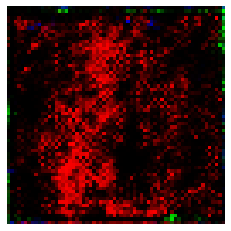

In [198]:
plt.imshow(((models['64x64']['main']['generator']([tf.random.normal((1, 512)), tf.random.normal((1, 4, 4, 512)), 
                                     tf.random.normal((1, 4, 4, 1)), tf.random.normal((1, 8, 8, 1)), 
                                     tf.random.normal((1, 16, 16, 1)), tf.random.normal((1, 32, 32, 1)), 
                                     tf.random.normal((1, 64, 64, 1))])[0]+1)*127.5).numpy().astype('uint8'))
plt.axis('off')
plt.show()

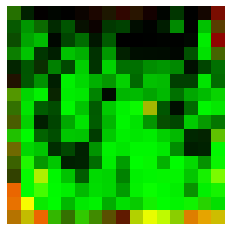

In [223]:
plt.imshow(((models['16x16']['main']['generator']([tf.random.normal((1, 512)), tf.random.normal((1, 4, 4, 512)), 
                                     tf.random.normal((1, 4, 4, 1)), tf.random.normal((1, 8, 8, 1)), 
                                     tf.random.normal((1, 16, 16, 1))])[0]+1)*127.5).numpy().astype('uint8'))
plt.axis('off')
plt.show()

In [199]:
# gan = StyleGAN()

In [200]:
# gan.grow_model()
# gan.stabilize_model()

In [201]:
# gan.stabilize_model()

In [81]:
# tf.keras.utils.plot_model(gan.generator, dpi = 64, show_shapes = True)
# tf.keras.utils.plot_model(gan.discriminator, dpi = 64, show_shapes = True)